In [1]:
   
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#from tensorflow.python.framework import ops from cnn_utils import *

from math import pi
import itertools
import time

%matplotlib inline

#with tf.Session() as sess:
#    hello = tf.constant('Hello, TensorFlow!')
#    print(sess.run(hello))


/Users/hagar/apps/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:

np.random.seed(seed=123)

class Vertex:
    """a polar coordinate vertex of unit length"""
    def __init__(self, index):
        self.index = index
        if(index == 0):
            self.theta = tf.constant([0.0], dtype=tf.float64, name = "theta" + str(index))
            self.phi = tf.constant([0.0], dtype=tf.float64, name = "phi" + str(index))
        else:   
            self.theta = tf.get_variable("theta" + str(index), [1] , dtype=tf.float64, 
                                     initializer=tf.constant_initializer(np.random.random_sample() * pi))
            if(index == 1):
                self.phi = tf.constant([0.0], dtype=tf.float64, name = "phi" + str(index))
            else:
                self.phi = tf.get_variable("phi" + str(index), [1] , dtype=tf.float64,
                                   initializer=tf.constant_initializer(np.random.random_sample() * 2 * pi))
        #print( index )
        #print(self.theta)
        #print(self.phi)
        sin_theta = tf.sin(self.theta)
        self.x = tf.multiply(sin_theta, tf.cos(self.phi) , name='x' + str(self.index))
        self.y = tf.multiply(sin_theta, tf.sin(self.phi) , name='y' + str(self.index))
        self.z = tf.cos(self.theta, name='z' + str(self.index))
        self.xyz = tf.concat([self.x, self.y, self.z], axis=0)


def make_vertextes( n_vertexes ):
    print('make vertextes')
    vertexes = []
    for i in range(n_vertexes):
        vertexes.append( Vertex(i) )
    return vertexes

def make_pairs( vertexes ):
    print('make pairs')
    list = []
    for pair in itertools.combinations(vertexes, 2):
        list.append( 1 / tf.norm(pair[0].xyz-pair[1].xyz))
    return tf.add_n(list)    



In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from sklearn import preprocessing

from pythreejs import *
import numpy as np
from IPython.display import display

def make_face_normals(verts,simplices):
    print(verts)
    print(simplices)
    face_normals = np.zeros((simplices.shape[0],3))
    for i in range(simplices.shape[0]):
        v = face_normals[i]
        for vertex_index in simplices[i]:
            #print(vertex_index)
            v += verts[vertex_index]
            
    face_normals = preprocessing.normalize(face_normals, norm='l2')   
    print(face_normals) 
    
    tuples=[]
    for i in range(face_normals.shape[0]):
        tuples.append((face_normals[i],i))
    return tuples    


def fix_simplex_normals(verts, simplices):
    #print('fix_simplex_normals')
    base = 1
    left = 0
    right = 2
    for face in simplices:
        vA = verts[ face[left] ];
        vB = verts[ face[base] ];
        vC = verts[ face[right] ];

        cb = vC - vB
        ab = vA - vB
        cross = np.cross( cb, ab )
        dot = np.dot( vA, cross)
        if dot < 0:
            #print( face )
            tmp  = face[left]
            face[left] = face[right]
            face[right] = tmp
            #print( dot )
            #print( face )
    return None

def make_vert_spheres(verts):
    spheres = []
    for v in verts:
        sphereGeom = SphereGeometry( radius = 0.03)
        sphereMesh = Mesh(geometry=sphereGeom, material = LambertMaterial(color='#444444',transparent=False, opacity=0.9))
        sphereMesh.position = v.tolist()
        spheres.append(sphereMesh)
    return spheres    


def makeMeshes(verts, simplices):
    #fix_simplex_normals(verts, simplices)
    fix_simplex_normals(verts, simplices)
    
    # https://github.com/jovyan/pythreejs
    cubeGeometry = PlainGeometry(vertices=verts, faces=simplices)   
    # , faceNormals=make_face_normals(pos,simplices)
    
    #,transparent=True, opacity=0.7, side='DoubleSide'
    myobjectCube = Mesh(geometry=cubeGeometry, material = LambertMaterial(color='#888888'))
    myobjectCube.material.wireframe = True
    camera = PerspectiveCamera(position=[-0.5, 6, -0.5], fov=25, aspect=1.0,
                          children=[DirectionalLight(color='#aaaaaa', position=[20, 20, 30], intensity=4)])
    spheres = make_vert_spheres(verts)
    sceneCube = Scene(children=[myobjectCube, AmbientLight(color='#aaaaaa', intensity=4)]+spheres)

    renderer = Renderer(camera=camera, background='black', background_opacity=1,
                            scene = sceneCube, controls=[OrbitControls(controlling=camera)], width='800',height='800')
   
    return renderer

In [4]:
import multiprocessing

n_vertexes = 12 # 12 -24 28 +32 36 40 -42 46

learning_rate = 6/(n_vertexes**2) 

start_time = time.time()

tf.reset_default_graph()
vertextes = make_vertextes(n_vertexes)
potential = make_pairs(vertextes)

multiplier = 1.02
learning_rate_placeholder = tf.placeholder(tf.float32, [], name='learning_rate')
print('make optimizer') 
optimizer = tf.train.GradientDescentOptimizer( learning_rate=learning_rate_placeholder ).minimize(potential)

#print([v.xyz for v in vertextes])
allPositions = tf.stack([v.xyz for v in vertextes])

NUM_THREADS = max(1, int( multiprocessing.cpu_count() / 2 ))
print('NUM_THREADS = ' + str(NUM_THREADS))
 
print('start session') 
#config = tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4, \
#                        allow_soft_placement=True, device_count = {'CPU': 4})
#config = tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4, \
#                        allow_soft_placement=True, device_count = {'CPU': 1})
#session = tf.Session(config=config)
session = tf.Session()

with session as sess:
    sess.run(tf.global_variables_initializer())
    last_p = 1e6
    last_was_equal = False
    for i in range(100000):
        if(i % 10 == 0):
            _ , p = sess.run([optimizer, potential], feed_dict={learning_rate_placeholder: learning_rate} )
            if(i % 200 == 0):
                print( str(i) + ' ' + "{0:.16f},  ".format(p)+ " ({0:.16e}),  ".format(last_p-p), end='')
            #if(i % 50 == 0):
            #    print( str(i) + ' ' + "{0:.8f}".format(p) + ' learning_rate = ' + 
            #          str( learning_rate) + ' multiplier = ' + str(multiplier) )
            #print( p - last_p )
            if abs(p - last_p) < 1e-11:
                if last_was_equal:
                    print('early stop')
                    break
                else:
                    last_was_equal = True
            else:
                last_was_equal = False
            #if( p < last_p ):
            #    learning_rate *= multiplier
            #else:
            #    learning_rate = max(1e-3, learning_rate/8)
            #    multiplier = 1 + (multiplier-1)/2
            last_p = p;
        else:
            sess.run( optimizer, feed_dict={learning_rate_placeholder: learning_rate} )  
    
    elapsed_time = time.time() - start_time
    print( str(elapsed_time)  + ' sec')
    print( str(i) + ' epochs' )
    
    verts = sess.run(allPositions, feed_dict={learning_rate_placeholder: learning_rate})    
    #print(verts)
    
    

make vertextes
make pairs
make optimizer
NUM_THREADS = 4
start session
0 59.4669038876221521,   (9.9994053309611243e+05),  200 49.1849353053400904,   (5.7139598262949676e-03),  400 49.1657811350764007,   (8.9218341017271996e-05),  600 49.1652823629845059,   (4.3264526397024383e-06),  800 49.1652550329637847,   (2.8173887045568335e-07),  1000 49.1652531964570301,   (1.9663175976347702e-08),  1200 49.1652530674665584,   (1.3914558394390042e-09),  1400 49.1652530583270959,   (9.8729913133865921e-11),  early stop
11.539005041122437 sec
1590 epochs


In [5]:

hull = ConvexHull(verts)

display(makeMeshes(verts, hull.simplices))

Renderer(background_opacity=1.0, camera=PerspectiveCamera(aspect=1.0, children=[DirectionalLight(color='#aaaaaa', intensity=4.0, position=[20.0, 20.0, 30.0], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0])], fov=25.0, position=[-0.5, 6.0, -0.5], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), controls=[OrbitControls(controlling=PerspectiveCamera(aspect=1.0, children=[DirectionalLight(color='#aaaaaa', intensity=4.0, position=[20.0, 20.0, 30.0], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0])], fov=25.0, position=[-0.5, 6.0, -0.5], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), target=[0.0, 0.0, 0.0])], effect=None, height='800', scene=Scene(children=[Mesh(geometry=PlainGeometry(faces=array([[ 8,  0,  6],
       [ 7,  9,  1],
       [10,  0,  8],
       [ 8, 11, 10],
       [ 9,  6,  2],
       [ 2,  6,  0],
       [ 1,  9,  2],
       [ 5,  7, 11],
       [ 5, 11,  8],
       [ 8,  6,  5],
       [ 5,  6,  9],
       [ 9,  7,  5],
       [ 0, 10,  4],
       [ 1,  2,  4],
       [ 4,  2,  0],
       [ 3, 10, 11],
       [ 3,  7,  1],
       [11,  7,  3],
       [ 1,  4,  3],
       [ 3,  4, 10]], dtype=uint32), vertices=array([[  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.94427836e-01,   0.00000000e+00,  -4.47212338e-01],
       [  7.23601222e-01,   5.25740623e-01,   4.47211444e-01],
       [  2.76398569e-01,  -8.50650787e-01,  -4.47210312e-01],
       [  7.23611236e-01,  -5.25722146e-01,   4.47216868e-01],
       [ -7.23610103e-01,   5.25725007e-01,  -4.47215438e-01],
       [ -2.76401401e-01,   8.50649059e-01,   4.47211862e-01],
       [  1.80519305e-06,  -1.63191942e-06,  -1.00000000e+00],
       [ -8.94427538e-01,  -6.50825814e-06,   4.47212905e-01],
       [  2.76388288e-01,   8.50651085e-01,  -4.47216094e-01],
       [ -2.76386827e-01,  -8.50652218e-01,   4.47214901e-01],
       [ -7.23602533e-01,  -5.25736749e-01,  -4.47213799e-01]], dtype=float32)), material=LambertMaterial(color='#888888', envMap=None, lightMap=None, map=None, specularMap=None, wireframe=True), position=[0.0, 0.0, 0.0], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), AmbientLight(color='#aaaaaa', position=[0.0, 0.0, 0.0], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#444444', envMap=None, lightMap=None, map=None, opacity=0.9, specularMap=None), position=[0.0, 0.0, 1.0], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#444444', envMap=None, lightMap=None, map=None, opacity=0.9, specularMap=None), position=[0.8944278204867999, 0.0, -0.4472123365239748], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#444444', envMap=None, lightMap=None, map=None, opacity=0.9, specularMap=None), position=[0.72360120131604, 0.5257406390518083, 0.44721145099760146], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#444444', envMap=None, lightMap=None, map=None, opacity=0.9, specularMap=None), position=[0.2763985642033769, -0.8506507860987373, -0.4472103239147234], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#444444', envMap=None, lightMap=None, map=None, opacity=0.9, specularMap=None), position=[0.7236112626662594, -0.5257221723940686, 0.44721688026706113], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#444444', envMap=None, lightMap=None, map=None, opacity=0.9, specularMap=None), position=[-0.7236100847470921, 0.5257250207533278, -0.44721543779952333], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#444444', envMap=None, lightMap=None, map=None, opacity=0.9, specularMap=None), position=[-0.2764013905026455, 0.8506490611682572, 0.4472118581408218], scale=[1.0, 1.0, 1.0], up=[

In [6]:


def add_ordered(set, index1, index2):
    if index1 < index2:
        set.add((index1, index2))
    else:
        set.add((index2, index1))

def get_edges(simplexes):
    edges = set()
    for s in simplexes:
        add_ordered(edges, s[0], s[1])
        add_ordered(edges, s[1], s[2])
        add_ordered(edges, s[0], s[2])
    return list(edges)    

class EdgeGroup:
    """all edges that are the same distance"""
    def __init__(self, distance):
        self.distance = distance
        self.count = 1
        
    def __str__(self):
        return str(self.distance) + ':' + str(self.count)


def make_surface_edge_groups(verts, simplexes, epsilon):
    groups = []
    edges = get_edges(simplexes)
    for e in edges:
        distance = np.linalg.norm(verts[e[0]] - verts[e[1]])
        found = False
        for g in groups:
            if abs(g[0] - distance) < epsilon:
                g[1]+=1
                found=True
                break
        if not found:      
            groups.append( [distance,1] ) 
                                 
    return list(groups)
    
epsilon = 1e-5    
groups = make_surface_edge_groups(verts, hull.simplices, epsilon) 
print(groups)

[[1.0514626468395802, 30]]


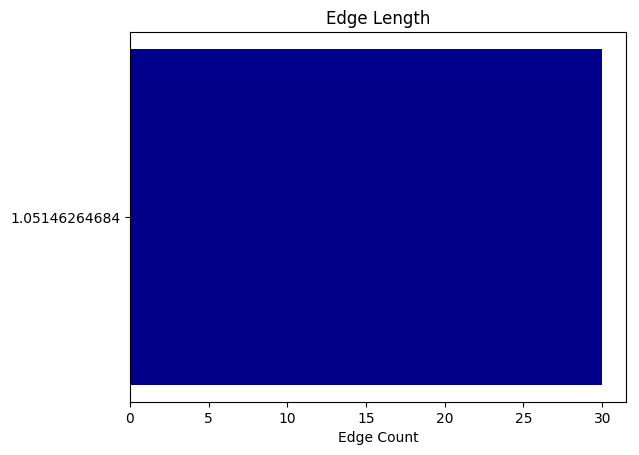

In [7]:
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = [group[0] for group in groups]
y_pos = np.arange(len(people))
performance = [group[1] for group in groups]

ax.barh(y_pos, performance, align='center',
        color='darkblue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Edge Count')
ax.set_title('Edge Length')

plt.show()

Todo:
1. fix face normals, https://github.com/mrdoob/three.js/blob/dev/src/core/Geometry.js computeFaceNormals
cubeGeometry.faceNormals

2. edge stats bar chart
4. transparent faces
5. edge color groups
5. manual change learning rate on split run on session
5. adaptive learning rate, exponetial average of last delta for each learning rate with N buckets randomly chosen each an increment more or less than best in the middle
5. save and load to file and use as init
5. graph
    1. e f v
    2. potential per ?
    3. groups
    4. periodic table of groups


## 12 Vertexes
![exampleOutput.png](exampleOutput.png)


## 32 Vertexes
![exampleOutput-32.png](exampleOutput-32.png)


In [ ]:
#cubeGeometry.faceNormals.__class__


In [ ]:
" {0:.16e},  ".format(1e-9)